# Data Analysis-- Supervised Learning
* Created on Mon Sep. 29 2021 by Shangying Wang
* Last Modified: Dec.15, 2021
* this code is used for prediction of the phenotypes from the combinatory motifs
* This code uses the convolutional neural network and LSTM.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import csv
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="ticks", color_codes=True)
#import pdb
from platform import python_version
print(python_version())

3.7.8


In [2]:
from tensorflow.keras.optimizers import SGD, Adam
from keras import layers,Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Average, BatchNormalization, LSTM, TimeDistributed
from tensorflow.keras.layers import Conv1D,MaxPool1D, concatenate
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.initializers import RandomNormal,HeNormal,GlorotNormal,HeUniform,LecunNormal,LecunUniform,Orthogonal
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from itertools import product
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
print(tf.__version__)

2.6.0


# For arrayed data analysis

## Load data from csv file

In [3]:
train_data=pd.read_csv('data/array_randomseed2_training221_wseq.csv',encoding= 'unicode_escape',sep=',')
test_data=pd.read_csv('data/array_randomseed2_test25_wseq.csv',encoding= 'unicode_escape',sep=',')
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)
train_data.drop(['motif.5', 'AA Seq','Parts','NaiveCM'], axis=1, inplace=True)
test_data.drop(['motif.5', 'AA Seq','Parts','NaiveCM'], axis=1, inplace=True)
test_data

,Cell Number,motif,motif.1,motif.2,motif.3,motif.4,Nalm 6 Cytotoxicity,IL7RaKLRG1 stemness
0,1686,4,9,1,14,0,0.002313,27.50
1,2019,9,2,7,14,0,0.410197,20.90
2,1685,5,14,0,0,0,0.808993,18.50
3,2842,8,7,3,14,0,0.552140,10.80
4,1197,10,10,1,14,0,0.050364,35.60
5,2748,8,3,2,14,0,0.708795,24.00
6,11301,1,7,10,14,0,0.266908,27.30
7,8695,1,3,6,14,0,0.808464,19.00
8,3685,10,6,3,14,0,0.528674,20.30
9,2393,6,9,3,14,0,0.748484,7.63


In [4]:
#data statistics
all_data = pd.concat([test_data, train_data])
max_cell=max(all_data['Cell Number'])
all_data['Cell Number']=all_data['Cell Number']/max_cell
train_data['Cell Number']=train_data['Cell Number']/max_cell
test_data['Cell Number']=test_data['Cell Number']/max_cell
stats_df = all_data.describe()
stats_df

,Cell Number,motif,motif.1,motif.2,motif.3,motif.4,Nalm 6 Cytotoxicity,IL7RaKLRG1 stemness
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
mean,0.255184,7.252033,6.926829,7.300813,12.475610,0.739837,0.615778,18.648821
std,0.210155,3.910412,3.815480,3.995783,4.147954,3.138536,0.253641,8.116347
min,0.003385,1.000000,1.000000,0.000000,0.000000,0.000000,0.002313,4.490000
25%,0.103734,3.000000,3.000000,3.000000,14.000000,0.000000,0.431323,12.500000
50%,0.194125,8.000000,8.000000,8.000000,14.000000,0.000000,0.655914,16.950000
75%,0.324693,11.000000,10.000000,11.000000,14.000000,0.000000,0.820133,23.050000
max,1.000000,13.000000,14.000000,14.000000,14.000000,14.000000,1.197448,46.200000


In [5]:
skew_vals1=all_data['Nalm 6 Cytotoxicity'].skew()
skew_vals1

-0.24443600883940755

In [6]:
skew_vals2=all_data['IL7RaKLRG1 stemness'].skew()
skew_vals2

0.9435370705807994

Text(0.5, 1.0, 'after np.log1p')

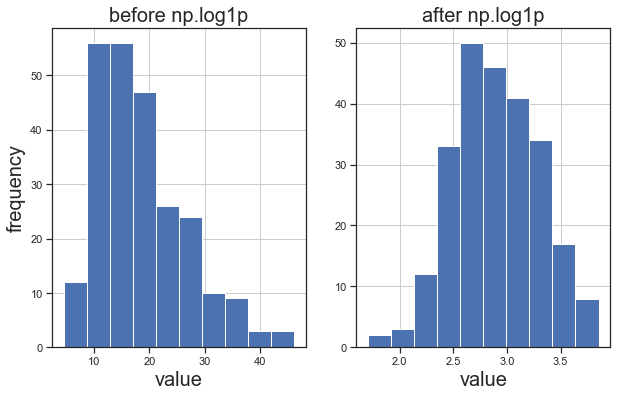

In [7]:
plt.figure(figsize=[10,20])
pheno=['IL7RaKLRG1 stemness']
new_data = all_data.copy()
pp=0
plt.subplot(3,2,1)
new_data[pheno[pp]].hist(bins=10)
plt.xlabel('value', fontsize=20)
plt.ylabel('frequency', fontsize=20)
plt.title('before np.log1p', fontsize=20)

plt.subplot(3,2,2)
new_data[pheno[pp]]=new_data[pheno[pp]].apply(np.log1p)
new_data[pheno[pp]].hist(bins=10)
plt.xlabel('value', fontsize=20)
#plt.ylabel('frequency', fontsize=20)
plt.title('after np.log1p', fontsize=20)

In [8]:
skew_vals2=new_data['IL7RaKLRG1 stemness'].skew()
skew_vals2

0.032751013323507334

In [9]:
train_data['IL7RaKLRG1 stemness'] = train_data['IL7RaKLRG1 stemness'].apply(np.log1p)
test_data['IL7RaKLRG1 stemness'] = test_data['IL7RaKLRG1 stemness'].apply(np.log1p)

In [10]:
stats_df = train_data.describe()
stats_df

,Cell Number,motif,motif.1,motif.2,motif.3,motif.4,Nalm 6 Cytotoxicity,IL7RaKLRG1 stemness
count,221.000000,221.00000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000
mean,0.257121,7.20362,6.791855,7.371041,12.656109,0.760181,0.628467,2.895283
std,0.211839,3.94959,3.800972,3.905459,3.898639,3.179687,0.252597,0.397182
min,0.003385,1.00000,1.000000,0.000000,0.000000,0.000000,0.004702,1.702928
25%,0.098971,3.00000,3.000000,3.000000,14.000000,0.000000,0.439604,2.602690
50%,0.209824,8.00000,8.000000,8.000000,14.000000,0.000000,0.666384,2.862201
75%,0.341985,11.00000,10.000000,11.000000,14.000000,0.000000,0.831310,3.173878
max,1.000000,13.00000,14.000000,14.000000,14.000000,14.000000,1.197448,3.854394


## Deep Neural Network for Nalm 6 Cytotoxicity

In [11]:
num_motifs=5
num_class=num_class=len(np.unique(new_data.iloc[:,1:(num_motifs+1)]))
np.unique(new_data.iloc[:,1:(num_motifs+1)])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [12]:
max_y=np.max(new_data['Nalm 6 Cytotoxicity'])
max_y

1.197447799

In [13]:
ICN_train, X_train, Y_train = train_data.iloc[:, :1], train_data.iloc[:,1:(num_motifs+1)], train_data['Nalm 6 Cytotoxicity']/max_y
ICN_test, X_test, Y_test = test_data.iloc[:, :1], test_data.iloc[:,1:(num_motifs+1)], test_data['Nalm 6 Cytotoxicity']/max_y

### One-hot encoding for 14 linear motifs: 

In [14]:
X_train_channel=to_categorical(X_train, num_classes=num_class)
X_test_channel=to_categorical(X_test, num_classes=num_class)
print(np.shape(X_test_channel)) #3D tensor with shape (batch_size, steps, features/channels)

(25, 5, 15)


In [15]:
output_dim = 1
batch_size = 10

In [16]:
stats_df = Y_train.describe()
stats_df

count    221.000000
mean       0.524839
std        0.210947
min        0.003927
25%        0.367118
50%        0.556504
75%        0.694235
max        1.000000
Name: Nalm 6 Cytotoxicity, dtype: float64

### CNN+LSTM 

In [17]:
#define two sets of inputs
#64, 4, 0.1, 64,0.5,4
input_position=Input(shape=(num_motifs, num_class), name='input_position')
input_ICN=Input(shape=(1), name='input_ICN')
#initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)#kernel_initializer=initializer, 
x=Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(num_motifs, num_class))(1.0*input_position)
#x=Conv1D(filters=16, kernel_size=3, padding='same', activation='relu')(x)
x=LSTM(4,return_sequences=True, dropout=0.3)(x)#return_sequences=True,
x = Flatten()(x)
#x = Dropout(0.5)(x)
#x = Dense(8*output_dim,activation='relu')(x)
model1 = keras.Model(inputs=input_position, outputs=x)


# combine the output of the two branches
combined = concatenate([model1.output, input_ICN])
# apply a FC layer and then a regression prediction on the
# combined outputs

z = Dense(50*output_dim, activation='relu')(combined)
#z = Dense(16*output_dim, activation='relu')(z)
z = Dropout(0.5)(z)
#z = Dense(4*output_dim, activation='relu')(z)
z = Dense(output_dim, activation='relu')(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = keras.Model(inputs=[input_position, input_ICN], outputs=z)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_position (InputLayer)     [(None, 5, 15)]      0                                            
__________________________________________________________________________________________________
tf.math.multiply (TFOpLambda)   (None, 5, 15)        0           input_position[0][0]             
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 5, 32)        1472        tf.math.multiply[0][0]           
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 5, 4)         592         conv1d[0][0]                     
____________________________________________________________________________________________

In [18]:
# Compile the model
model.compile(
    #loss=keras.losses.MeanSquaredLogarithmicError(),
    loss=keras.losses.MeanAbsoluteError(),
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
    #optimizer=tfa.optimizers.RectifiedAdam(lr=1e-3),
    #optimizer=Adam(lr=0.0001), #Adam optimizer
    #optimizer=SGD(lr=0.001, momentum=0.99),
    metrics=[tf.keras.metrics.MeanSquaredError()])

history = model.fit([X_train_channel, ICN_train], Y_train,  batch_size=batch_size, epochs=1200, verbose=1)
#validation_data=([X_test_channel, ICN_test], Y_test), 

Epoch 1/1200
23/23 [==============================] - 2s 4ms/step - loss: 0.4934 - mean_squared_error: 0.2903
Epoch 2/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.4620 - mean_squared_error: 0.2615
Epoch 3/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.4230 - mean_squared_error: 0.2256
Epoch 4/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.3891 - mean_squared_error: 0.2033
Epoch 5/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.3498 - mean_squared_error: 0.1670
Epoch 6/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.3209 - mean_squared_error: 0.1494
Epoch 7/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.2896 - mean_squared_error: 0.1247
Epoch 8/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.2698 - mean_squared_error: 0.1110
Epoch 9/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.2424 - mean_squared_error: 0.0916
Epoch 10/1

23/23 [==============================] - 0s 3ms/step - loss: 0.1659 - mean_squared_error: 0.0459
Epoch 75/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1503 - mean_squared_error: 0.0382
Epoch 76/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1665 - mean_squared_error: 0.0443
Epoch 77/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.1637 - mean_squared_error: 0.0433
Epoch 78/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.1618 - mean_squared_error: 0.0423
Epoch 79/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.1684 - mean_squared_error: 0.0446
Epoch 80/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.1528 - mean_squared_error: 0.0395
Epoch 81/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1685 - mean_squared_error: 0.0447
Epoch 82/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1549 - mean_squared_error: 0.0382
Epoch 83/1200
2

23/23 [==============================] - 0s 3ms/step - loss: 0.1335 - mean_squared_error: 0.0283
Epoch 148/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1337 - mean_squared_error: 0.0286
Epoch 149/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1502 - mean_squared_error: 0.0361
Epoch 150/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1424 - mean_squared_error: 0.0341
Epoch 151/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1352 - mean_squared_error: 0.0311
Epoch 152/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1328 - mean_squared_error: 0.0299
Epoch 153/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1342 - mean_squared_error: 0.0320
Epoch 154/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1363 - mean_squared_error: 0.0328
Epoch 155/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1407 - mean_squared_error: 0.0331
Epoch 1

23/23 [==============================] - 0s 3ms/step - loss: 0.1272 - mean_squared_error: 0.0263
Epoch 221/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1343 - mean_squared_error: 0.0303
Epoch 222/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1260 - mean_squared_error: 0.0259
Epoch 223/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1273 - mean_squared_error: 0.0259
Epoch 224/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1222 - mean_squared_error: 0.0245
Epoch 225/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1204 - mean_squared_error: 0.0245
Epoch 226/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1200 - mean_squared_error: 0.0242
Epoch 227/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1194 - mean_squared_error: 0.0261
Epoch 228/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1094 - mean_squared_error: 0.0206
Epoch 2

23/23 [==============================] - 0s 3ms/step - loss: 0.1162 - mean_squared_error: 0.0238
Epoch 294/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1238 - mean_squared_error: 0.0258
Epoch 295/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1166 - mean_squared_error: 0.0236
Epoch 296/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1288 - mean_squared_error: 0.0270
Epoch 297/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1137 - mean_squared_error: 0.0217
Epoch 298/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1216 - mean_squared_error: 0.0247
Epoch 299/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1160 - mean_squared_error: 0.0231
Epoch 300/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1211 - mean_squared_error: 0.0257
Epoch 301/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1216 - mean_squared_error: 0.0258
Epoch 3

23/23 [==============================] - 0s 3ms/step - loss: 0.1082 - mean_squared_error: 0.0204
Epoch 367/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1056 - mean_squared_error: 0.0185
Epoch 368/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1065 - mean_squared_error: 0.0192
Epoch 369/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1120 - mean_squared_error: 0.0213
Epoch 370/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1096 - mean_squared_error: 0.0203
Epoch 371/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1087 - mean_squared_error: 0.0208
Epoch 372/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1081 - mean_squared_error: 0.0195
Epoch 373/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1023 - mean_squared_error: 0.0180
Epoch 374/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0990 - mean_squared_error: 0.0173
Epoch 3

23/23 [==============================] - 0s 3ms/step - loss: 0.1048 - mean_squared_error: 0.0190
Epoch 440/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1032 - mean_squared_error: 0.0189
Epoch 441/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0991 - mean_squared_error: 0.0172
Epoch 442/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0999 - mean_squared_error: 0.0165
Epoch 443/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1009 - mean_squared_error: 0.0176
Epoch 444/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1042 - mean_squared_error: 0.0185
Epoch 445/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1050 - mean_squared_error: 0.0181
Epoch 446/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0986 - mean_squared_error: 0.0173
Epoch 447/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1072 - mean_squared_error: 0.0202
Epoch 4

23/23 [==============================] - 0s 3ms/step - loss: 0.0943 - mean_squared_error: 0.0155
Epoch 513/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1018 - mean_squared_error: 0.0175
Epoch 514/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0995 - mean_squared_error: 0.0178
Epoch 515/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0935 - mean_squared_error: 0.0153
Epoch 516/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1029 - mean_squared_error: 0.0176
Epoch 517/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0940 - mean_squared_error: 0.0170
Epoch 518/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.1004 - mean_squared_error: 0.0169
Epoch 519/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0938 - mean_squared_error: 0.0154
Epoch 520/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0913 - mean_squared_error: 0.0145
Epoch 5

23/23 [==============================] - 0s 3ms/step - loss: 0.0939 - mean_squared_error: 0.0150
Epoch 586/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0923 - mean_squared_error: 0.0155
Epoch 587/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0916 - mean_squared_error: 0.0149
Epoch 588/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.0952 - mean_squared_error: 0.0159
Epoch 589/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.0933 - mean_squared_error: 0.0152
Epoch 590/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.0899 - mean_squared_error: 0.0146
Epoch 591/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0960 - mean_squared_error: 0.0156
Epoch 592/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0899 - mean_squared_error: 0.0144
Epoch 593/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0875 - mean_squared_error: 0.0142
Epoch 5

23/23 [==============================] - 0s 4ms/step - loss: 0.0862 - mean_squared_error: 0.0131
Epoch 659/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0877 - mean_squared_error: 0.0135
Epoch 660/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0886 - mean_squared_error: 0.0134
Epoch 661/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0901 - mean_squared_error: 0.0141
Epoch 662/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0913 - mean_squared_error: 0.0144
Epoch 663/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0920 - mean_squared_error: 0.0141
Epoch 664/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0890 - mean_squared_error: 0.0131
Epoch 665/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0947 - mean_squared_error: 0.0149
Epoch 666/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.0939 - mean_squared_error: 0.0150
Epoch 6

23/23 [==============================] - 0s 3ms/step - loss: 0.0881 - mean_squared_error: 0.0132
Epoch 732/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0836 - mean_squared_error: 0.0119
Epoch 733/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0892 - mean_squared_error: 0.0142
Epoch 734/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0893 - mean_squared_error: 0.0145
Epoch 735/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0850 - mean_squared_error: 0.0125
Epoch 736/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0881 - mean_squared_error: 0.0132
Epoch 737/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.0950 - mean_squared_error: 0.0162
Epoch 738/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0875 - mean_squared_error: 0.0129
Epoch 739/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.0924 - mean_squared_error: 0.0147
Epoch 7

23/23 [==============================] - 0s 3ms/step - loss: 0.0784 - mean_squared_error: 0.0109
Epoch 805/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0842 - mean_squared_error: 0.0121
Epoch 806/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0876 - mean_squared_error: 0.0137
Epoch 807/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0816 - mean_squared_error: 0.0113
Epoch 808/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0920 - mean_squared_error: 0.0144
Epoch 809/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0847 - mean_squared_error: 0.0127
Epoch 810/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0857 - mean_squared_error: 0.0135
Epoch 811/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0852 - mean_squared_error: 0.0129
Epoch 812/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0850 - mean_squared_error: 0.0129
Epoch 8

23/23 [==============================] - 0s 3ms/step - loss: 0.0824 - mean_squared_error: 0.0124
Epoch 878/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.0861 - mean_squared_error: 0.0129
Epoch 879/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0767 - mean_squared_error: 0.0106
Epoch 880/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0807 - mean_squared_error: 0.0111
Epoch 881/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0841 - mean_squared_error: 0.0129
Epoch 882/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0849 - mean_squared_error: 0.0120
Epoch 883/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0782 - mean_squared_error: 0.0111
Epoch 884/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0818 - mean_squared_error: 0.0115
Epoch 885/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.0822 - mean_squared_error: 0.0113
Epoch 8

23/23 [==============================] - 0s 3ms/step - loss: 0.0876 - mean_squared_error: 0.0133
Epoch 951/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0761 - mean_squared_error: 0.0106
Epoch 952/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0876 - mean_squared_error: 0.0132
Epoch 953/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0814 - mean_squared_error: 0.0125
Epoch 954/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0755 - mean_squared_error: 0.0097
Epoch 955/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0782 - mean_squared_error: 0.0115
Epoch 956/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0818 - mean_squared_error: 0.0111
Epoch 957/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0744 - mean_squared_error: 0.0092
Epoch 958/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0788 - mean_squared_error: 0.0107
Epoch 9

23/23 [==============================] - 0s 3ms/step - loss: 0.0807 - mean_squared_error: 0.0114
Epoch 1024/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0752 - mean_squared_error: 0.0099
Epoch 1025/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0776 - mean_squared_error: 0.0103
Epoch 1026/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0794 - mean_squared_error: 0.0111
Epoch 1027/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0771 - mean_squared_error: 0.0102
Epoch 1028/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0764 - mean_squared_error: 0.0099
Epoch 1029/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0838 - mean_squared_error: 0.0115
Epoch 1030/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0821 - mean_squared_error: 0.0115
Epoch 1031/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0783 - mean_squared_error: 0.0111

23/23 [==============================] - 0s 3ms/step - loss: 0.0725 - mean_squared_error: 0.0095
Epoch 1096/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0757 - mean_squared_error: 0.0104
Epoch 1097/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0808 - mean_squared_error: 0.0110
Epoch 1098/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0784 - mean_squared_error: 0.0104
Epoch 1099/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0797 - mean_squared_error: 0.0110
Epoch 1100/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0782 - mean_squared_error: 0.0102
Epoch 1101/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0753 - mean_squared_error: 0.0106
Epoch 1102/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0748 - mean_squared_error: 0.0101
Epoch 1103/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0727 - mean_squared_error: 0.0095

23/23 [==============================] - 0s 3ms/step - loss: 0.0725 - mean_squared_error: 0.0087
Epoch 1168/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0765 - mean_squared_error: 0.0097
Epoch 1169/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0728 - mean_squared_error: 0.0090
Epoch 1170/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0768 - mean_squared_error: 0.0096
Epoch 1171/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0741 - mean_squared_error: 0.0106
Epoch 1172/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0734 - mean_squared_error: 0.0096
Epoch 1173/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0787 - mean_squared_error: 0.0104
Epoch 1174/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.0756 - mean_squared_error: 0.0098
Epoch 1175/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.0744 - mean_squared_error: 0.0099

In [19]:
train_scores = model.evaluate([X_train_channel,ICN_train], Y_train, verbose=0)
test_scores = model.evaluate([X_test_channel,ICN_test], Y_test, verbose=0)
print("MSE:", train_scores[1])
print("MSE:", test_scores[1])

MSE: 0.004898003302514553
MSE: 0.016796788200736046


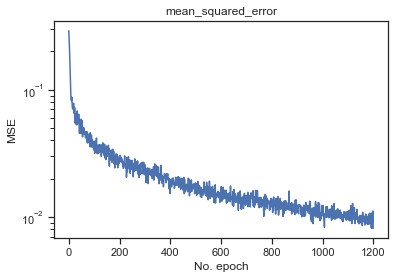

In [20]:
p1=plt.plot(history.history['mean_squared_error'])
#p2=plt.plot(history.history['val_mean_squared_error'])
plt.title('mean_squared_error')
plt.ylabel('MSE')
plt.xlabel('No. epoch')
plt.yscale('log')
#plt.legend([p1,p2], ['training','validation'])
plt.show()

In [21]:
pred_train=model.predict([X_train_channel,ICN_train])*max_y
pred_test=model.predict([X_test_channel,ICN_test])*max_y
# pred_train=np.dot(pred_train_sc, np.diag(max_y))
# pred_test=np.dot(pred_test_sc,np.diag(max_y))

(-0.03802068355, 0.8493271745500001, -0.03802068355, 0.8493271745500001)

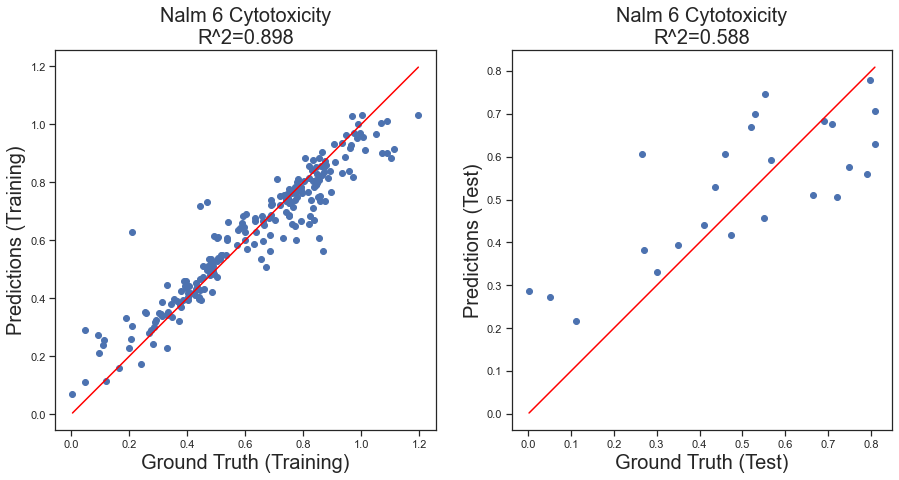

In [22]:
from sklearn.metrics import r2_score
title_list=['Nalm 6 Cytotoxicity','IL7RaKLRG1 stemness']
plt.figure(figsize=[15,70])
i=0
gt=Y_train*max_y
plt.subplot(1,2,1)
plt.scatter(gt,pred_train)
xmin=min(min(gt),min(pred_train))
xmax=max(max(gt),max(pred_train))
xline=np.linspace(xmin,xmax,10)
plt.plot(xline,xline,color='red')
plt.xlabel('Ground Truth (Training)', fontsize=20)
plt.ylabel('Predictions (Training)', fontsize=20)
correlation_matrix = np.corrcoef(gt, pred_train[:,0])
corr = correlation_matrix[0,1]
r_squared = corr**2
plt.title(title_list[i]+'\n'+'R^2='+str(r_squared)[:5], fontsize=20)
plt.axis('square')

plt.subplot(1,2,2)
gt=Y_test*max_y
plt.scatter(gt,pred_test[:,i])
xmin=min(min(gt),min(pred_test))
xmax=max(max(gt),max(pred_test[:,i]))
xline=np.linspace(xmin,xmax,10)
plt.plot(xline,xline,color='red')
plt.xlabel('Ground Truth (Test)', fontsize=20)
plt.ylabel('Predictions (Test)', fontsize=20)
correlation_matrix = np.corrcoef(gt, pred_test[:,0])
corr = correlation_matrix[0,1]
r_squared = corr**2
plt.title(title_list[i]+'\n'+'R^2='+str(r_squared)[:5], fontsize=20)
plt.axis('square')

## Ensemble Predistions 

In [ ]:
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_12152021_CNN_LSTM_Cytotoxicity_1.h5')
pred_test1=model.predict([X_test_channel,ICN_test])
pred_train1=model.predict([X_train_channel,ICN_train])
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_12152021_CNN_LSTM_Cytotoxicity_2.h5')
pred_test2=model.predict([X_test_channel,ICN_test])
pred_train2=model.predict([X_train_channel,ICN_train])
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_12152021_CNN_LSTM_Cytotoxicity_3.h5')
pred_test3=model.predict([X_test_channel,ICN_test])
pred_train3=model.predict([X_train_channel,ICN_train])
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_12152021_CNN_LSTM_Cytotoxicity_4.h5')
pred_test4=model.predict([X_test_channel,ICN_test])
pred_train4=model.predict([X_train_channel,ICN_train])
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_12152021_CNN_LSTM_Cytotoxicity_5.h5')
pred_test5=model.predict([X_test_channel,ICN_test])
pred_train5=model.predict([X_train_channel,ICN_train])
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_12152021_CNN_LSTM_Cytotoxicity_6.h5')
pred_test6=model.predict([X_test_channel,ICN_test])
pred_train6=model.predict([X_train_channel,ICN_train])
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_12152021_CNN_LSTM_Cytotoxicity_7.h5')
pred_test7=model.predict([X_test_channel,ICN_test])
pred_train7=model.predict([X_train_channel,ICN_train])
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_12152021_CNN_LSTM_Cytotoxicity_8.h5')
pred_test8=model.predict([X_test_channel,ICN_test])
pred_train8=model.predict([X_train_channel,ICN_train])
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_12152021_CNN_LSTM_Cytotoxicity_9.h5')
pred_test9=model.predict([X_test_channel,ICN_test])
pred_train9=model.predict([X_train_channel,ICN_train])
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_12152021_CNN_LSTM_Cytotoxicity_10.h5')
pred_test10=model.predict([X_test_channel,ICN_test])
pred_train10=model.predict([X_train_channel,ICN_train])
pred_test=(pred_test1+pred_test2+pred_test3+pred_test4+pred_test5+pred_test6+pred_test7+pred_test8+pred_test9+pred_test10)/10
pred_train=(pred_train1+pred_train2+pred_train3+pred_train4+pred_train5+pred_train6+pred_train7+pred_train8+pred_train9+pred_train10)/10
df = pd.DataFrame(np.around(pred_test,3), columns = ['Column_1'])
df.T

In [ ]:
from sklearn.metrics import r2_score
title_list=['Nalm 6 Cytotoxicity','IL7RaKLRG1 stemness']
plt.figure(figsize=[15,70])
i=0
gt=Y_train*max_y
plt.subplot(1,2,1)
plt.scatter(gt,pred_train)
xmin=min(min(gt),min(pred_train))
xmax=max(max(gt),max(pred_train))
xline=np.linspace(xmin,xmax,10)
plt.plot(xline,xline,color='red')
plt.xlabel('Ground Truth (Training)', fontsize=20)
plt.ylabel('Predictions (Training)', fontsize=20)
correlation_matrix = np.corrcoef(gt, pred_train[:,0])
corr = correlation_matrix[0,1]
r_squared = corr**2
plt.title(title_list[i]+'\n'+'R^2='+str(r_squared)[:5], fontsize=20)
plt.axis('square')

plt.subplot(1,2,2)
gt=Y_test*max_y
plt.scatter(gt,pred_test[:,i])
xmin=min(min(gt),min(pred_test))
xmax=max(max(gt),max(pred_test[:,i]))
xline=np.linspace(xmin,xmax,10)
plt.plot(xline,xline,color='red')
plt.xlabel('Ground Truth (Test)', fontsize=20)
plt.ylabel('Predictions (Test)', fontsize=20)
correlation_matrix = np.corrcoef(gt, pred_test[:,0])
corr = correlation_matrix[0,1]
r_squared = corr**2
plt.title(title_list[i]+'\n'+'R^2='+str(r_squared)[:5], fontsize=20)
plt.axis('square')

## Deep Neural Network for IL7RaKLRG1 stemness

In [23]:
max_y=np.max(new_data['IL7RaKLRG1 stemness'])
max_y

3.8543938925915096

In [24]:
Y_train = train_data['IL7RaKLRG1 stemness']/max_y
Y_test = test_data['IL7RaKLRG1 stemness']/max_y

In [25]:
#define two sets of inputs
#64, 4, 0.1, 64,0.5,4
input_position=Input(shape=(num_motifs, num_class), name='input_position')
input_ICN=Input(shape=(1), name='input_ICN')
#initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)#kernel_initializer=initializer, 
x=Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(num_motifs, num_class))(1.0*input_position)
#x=Conv1D(filters=16, kernel_size=3, padding='same', activation='relu')(x)
x=LSTM(4,return_sequences=True, dropout=0.3)(x)#return_sequences=True,
x = Flatten()(x)
#x = Dropout(0.5)(x)
#x = Dense(8*output_dim,activation='relu')(x)
model1 = keras.Model(inputs=input_position, outputs=x)


# combine the output of the two branches
combined = concatenate([model1.output, input_ICN])
# apply a FC layer and then a regression prediction on the
# combined outputs

z = Dense(50*output_dim, activation='relu')(combined)
#z = Dense(16*output_dim, activation='relu')(z)
z = Dropout(0.5)(z)
#z = Dense(4*output_dim, activation='relu')(z)
z = Dense(output_dim, activation='relu')(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = keras.Model(inputs=[input_position, input_ICN], outputs=z)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_position (InputLayer)     [(None, 5, 15)]      0                                            
__________________________________________________________________________________________________
tf.math.multiply_1 (TFOpLambda) (None, 5, 15)        0           input_position[0][0]             
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 5, 32)        1472        tf.math.multiply_1[0][0]         
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 5, 4)         592         conv1d_1[0][0]                   
____________________________________________________________________________________________

In [26]:
# Compile the model
model.compile(
    #loss=keras.losses.MeanSquaredLogarithmicError(),
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
    #optimizer=tfa.optimizers.RectifiedAdam(lr=1e-3),
    #optimizer=Adam(lr=0.0001), #Adam optimizer
    #optimizer=SGD(lr=0.001, momentum=0.99),
    metrics=[tf.keras.metrics.MeanSquaredError()])

history = model.fit([X_train_channel, ICN_train], Y_train, batch_size=batch_size, epochs=1200, verbose=1)
#validation_data=([X_test_channel, ICN_test], Y_test), 

Epoch 1/1200
23/23 [==============================] - 3s 5ms/step - loss: 0.5324 - mean_squared_error: 0.5324
Epoch 2/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.5091 - mean_squared_error: 0.5091
Epoch 3/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.4638 - mean_squared_error: 0.4638
Epoch 4/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.4206 - mean_squared_error: 0.4206
Epoch 5/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.3704 - mean_squared_error: 0.3704
Epoch 6/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.3314 - mean_squared_error: 0.3314
Epoch 7/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.2924 - mean_squared_error: 0.2924
Epoch 8/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.2485 - mean_squared_error: 0.2485
Epoch 9/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.1973 - mean_squared_error: 0.1973
Epoch 10/1

23/23 [==============================] - 0s 3ms/step - loss: 0.0369 - mean_squared_error: 0.0369
Epoch 75/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 76/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0252 - mean_squared_error: 0.0252
Epoch 77/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 78/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0352 - mean_squared_error: 0.0352
Epoch 79/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0292 - mean_squared_error: 0.0292
Epoch 80/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0366 - mean_squared_error: 0.0366
Epoch 81/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0364 - mean_squared_error: 0.0364
Epoch 82/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0355 - mean_squared_error: 0.0355
Epoch 83/1200
2

23/23 [==============================] - 0s 3ms/step - loss: 0.0264 - mean_squared_error: 0.0264
Epoch 148/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0279 - mean_squared_error: 0.0279
Epoch 149/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0259 - mean_squared_error: 0.0259
Epoch 150/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0293 - mean_squared_error: 0.0293
Epoch 151/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0249 - mean_squared_error: 0.0249
Epoch 152/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0247 - mean_squared_error: 0.0247
Epoch 153/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0279 - mean_squared_error: 0.0279
Epoch 154/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0212 - mean_squared_error: 0.0212
Epoch 155/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0265 - mean_squared_error: 0.0265
Epoch 1

23/23 [==============================] - 0s 3ms/step - loss: 0.0207 - mean_squared_error: 0.0207
Epoch 221/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.0214 - mean_squared_error: 0.0214
Epoch 222/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0234 - mean_squared_error: 0.0234
Epoch 223/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.0203 - mean_squared_error: 0.0203
Epoch 224/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.0218 - mean_squared_error: 0.0218
Epoch 225/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0193 - mean_squared_error: 0.0193
Epoch 226/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0211 - mean_squared_error: 0.0211
Epoch 227/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0202 - mean_squared_error: 0.0202
Epoch 228/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0233 - mean_squared_error: 0.0233
Epoch 2

23/23 [==============================] - 0s 3ms/step - loss: 0.0156 - mean_squared_error: 0.0156
Epoch 294/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0160 - mean_squared_error: 0.0160
Epoch 295/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0166 - mean_squared_error: 0.0166
Epoch 296/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0169 - mean_squared_error: 0.0169
Epoch 297/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.0184 - mean_squared_error: 0.0184
Epoch 298/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0186 - mean_squared_error: 0.0186
Epoch 299/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0176 - mean_squared_error: 0.0176
Epoch 300/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0170 - mean_squared_error: 0.0170
Epoch 301/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0183 - mean_squared_error: 0.0183
Epoch 3

23/23 [==============================] - 0s 4ms/step - loss: 0.0142 - mean_squared_error: 0.0142
Epoch 367/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0127 - mean_squared_error: 0.0127
Epoch 368/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0146 - mean_squared_error: 0.0146
Epoch 369/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0147 - mean_squared_error: 0.0147
Epoch 370/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0133 - mean_squared_error: 0.0133
Epoch 371/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0141 - mean_squared_error: 0.0141
Epoch 372/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0150 - mean_squared_error: 0.0150
Epoch 373/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0143 - mean_squared_error: 0.0143
Epoch 374/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0151 - mean_squared_error: 0.0151
Epoch 3

23/23 [==============================] - 0s 3ms/step - loss: 0.0123 - mean_squared_error: 0.0123
Epoch 440/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 441/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0125 - mean_squared_error: 0.0125
Epoch 442/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 443/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0106 - mean_squared_error: 0.0106
Epoch 444/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 445/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0127 - mean_squared_error: 0.0127
Epoch 446/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0106 - mean_squared_error: 0.0106
Epoch 447/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 4

23/23 [==============================] - 0s 3ms/step - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 513/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 514/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 515/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 516/1200
23/23 [==============================] - 0s 4ms/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 517/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 518/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 519/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 520/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 5

23/23 [==============================] - 0s 3ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 586/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 587/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 588/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 589/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 590/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 591/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 592/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 593/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 5

23/23 [==============================] - 0s 3ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 659/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 660/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 661/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 662/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 663/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 664/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 665/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 666/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 6

23/23 [==============================] - 0s 3ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 732/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 733/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 734/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 735/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 736/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 737/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 738/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 739/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 7

23/23 [==============================] - 0s 3ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 805/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 806/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 807/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 808/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 809/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 810/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 811/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 812/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 8

23/23 [==============================] - 0s 3ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 878/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 879/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 880/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 881/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 882/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 883/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 884/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 885/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 8

23/23 [==============================] - 0s 3ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 951/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 952/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 953/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 954/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 955/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 956/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0049 - mean_squared_error: 0.0049  
Epoch 957/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 958/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch

23/23 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 1024/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1025/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 1026/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 1027/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037  
Epoch 1028/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 1029/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1030/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 1031/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0042 - mean_squared_error: 0.00

23/23 [==============================] - 0s 3ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1096/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1097/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 1098/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 1099/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 1100/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1101/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1102/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 1103/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0038 - mean_squared_error: 0.0038

23/23 [==============================] - 0s 3ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1168/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 1169/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 1170/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1171/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 1172/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1173/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 1174/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 1175/1200
23/23 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037

In [27]:
train_scores = model.evaluate([X_train_channel,ICN_train], Y_train, verbose=0)
test_scores = model.evaluate([X_test_channel,ICN_test], Y_test, verbose=0)
print("MSE:", train_scores[1])
print("MSE:", test_scores[1])

MSE: 0.0021287763956934214
MSE: 0.006348497699946165


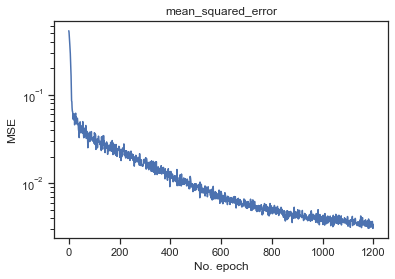

In [28]:
p1=plt.plot(history.history['mean_squared_error'])
#p2=plt.plot(history.history['val_mean_squared_error'])
plt.title('mean_squared_error')
plt.ylabel('MSE')
plt.xlabel('No. epoch')
plt.yscale('log')
#plt.legend([p1,p2], ['training','validation'])
plt.show()

In [29]:
# pred_train=model.predict([X_train_channel,ICN_train])
# pred_test=model.predict([X_test_channel,ICN_test])
pred_train=np.exp(model.predict([X_train_channel,ICN_train])*max_y)-1
pred_test=np.exp(model.predict([X_test_channel,ICN_test])*max_y)-1

In [30]:
np.shape(pred_test)

(25, 1)

(5.677237350463869, 42.25801564025879, 5.677237510681152, 42.25801580047607)

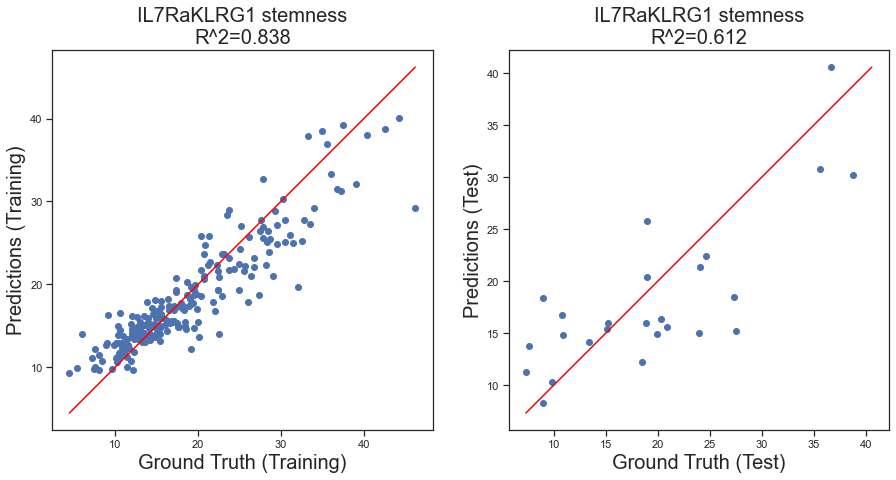

In [31]:
from sklearn.metrics import r2_score
title_list=['Nalm 6 Cytotoxicity','IL7RaKLRG1 stemness']
plt.figure(figsize=[15,70])
i=1
gt=np.exp(Y_train*max_y)-1
plt.subplot(1,2,1)
plt.scatter(gt,pred_train)
xmin=min(min(gt),min(pred_train))
xmax=max(max(gt),max(pred_train))
xline=np.linspace(xmin,xmax,10)
plt.plot(xline,xline,color='red')
plt.xlabel('Ground Truth (Training)', fontsize=20)
plt.ylabel('Predictions (Training)', fontsize=20)
correlation_matrix = np.corrcoef(gt, pred_train[:,0])
corr = correlation_matrix[0,1]
r_squared = corr**2
plt.title(title_list[i]+'\n'+'R^2='+str(r_squared)[:5], fontsize=20)
plt.axis('square')

plt.subplot(1,2,2)
gt=np.exp(Y_test*max_y)-1
plt.scatter(gt,pred_test)
xmin=min(min(gt),min(pred_test))
xmax=max(max(gt),max(pred_test))
xline=np.linspace(xmin,xmax,10)
plt.plot(xline,xline,color='red')
plt.xlabel('Ground Truth (Test)', fontsize=20)
plt.ylabel('Predictions (Test)', fontsize=20)
correlation_matrix = np.corrcoef(gt, pred_test[:,0])
corr = correlation_matrix[0,1]
r_squared = corr**2
plt.title(title_list[i]+'\n'+'R^2='+str(r_squared)[:5], fontsize=20)
plt.axis('square')

## Ensemble Predistions 

In [ ]:
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_12152021_CNN_LSTM_stemness_1.h5')
pred_test1=model.predict([X_test_channel,ICN_test])
pred_train1=model.predict([X_train_channel,ICN_train])
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_12152021_CNN_LSTM_stemness_2.h5')
pred_test2=model.predict([X_test_channel,ICN_test])
pred_train2=model.predict([X_train_channel,ICN_train])
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_12152021_CNN_LSTM_stemness_3.h5')
pred_test3=model.predict([X_test_channel,ICN_test])
pred_train3=model.predict([X_train_channel,ICN_train])
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_12152021_CNN_LSTM_stemness_4.h5')
pred_test4=model.predict([X_test_channel,ICN_test])
pred_train4=model.predict([X_train_channel,ICN_train])
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_12152021_CNN_LSTM_stemness_5.h5')
pred_test5=model.predict([X_test_channel,ICN_test])
pred_train5=model.predict([X_train_channel,ICN_train])
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_12152021_CNN_LSTM_stemness_6.h5')
pred_test6=model.predict([X_test_channel,ICN_test])
pred_train6=model.predict([X_train_channel,ICN_train])
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_12152021_CNN_LSTM_stemness_7.h5')
pred_test7=model.predict([X_test_channel,ICN_test])
pred_train7=model.predict([X_train_channel,ICN_train])
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_12152021_CNN_LSTM_stemness_8.h5')
pred_test8=model.predict([X_test_channel,ICN_test])
pred_train8=model.predict([X_train_channel,ICN_train])
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_12152021_CNN_LSTM_stemness_9.h5')
pred_test9=model.predict([X_test_channel,ICN_test])
pred_train9=model.predict([X_train_channel,ICN_train])
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_12152021_CNN_LSTM_stemness_10.h5')
pred_test10=model.predict([X_test_channel,ICN_test])
pred_train10=model.predict([X_train_channel,ICN_train])
pred_test=(pred_test1+pred_test2+pred_test3+pred_test4+pred_test5+pred_test6+pred_test7+pred_test8+pred_test9+pred_test10)/10
pred_train=(pred_train1+pred_train2+pred_train3+pred_train4+pred_train5+pred_train6+pred_train7+pred_train8+pred_train9+pred_train10)/10
df = pd.DataFrame(np.around(pred_test,3), columns = ['Column_1'])
df.T

In [ ]:
from sklearn.metrics import r2_score
title_list=['Nalm 6 Cytotoxicity','IL7RaKLRG1 stemness']
plt.figure(figsize=[15,70])
i=1
gt=np.exp(Y_train*max_y)-1
plt.subplot(1,2,1)
plt.scatter(gt,pred_train)
xmin=min(min(gt),min(pred_train))
xmax=max(max(gt),max(pred_train))
xline=np.linspace(xmin,xmax,10)
plt.plot(xline,xline,color='red')
plt.xlabel('Ground Truth (Training)', fontsize=20)
plt.ylabel('Predictions (Training)', fontsize=20)
correlation_matrix = np.corrcoef(gt, pred_train[:,0])
corr = correlation_matrix[0,1]
r_squared = corr**2
plt.title(title_list[i]+'\n'+'R^2='+str(r_squared)[:5], fontsize=20)
plt.axis('square')

plt.subplot(1,2,2)
gt=np.exp(Y_test*max_y)-1
plt.scatter(gt,pred_test)
xmin=min(min(gt),min(pred_test))
xmax=max(max(gt),max(pred_test))
xline=np.linspace(xmin,xmax,10)
plt.plot(xline,xline,color='red')
plt.xlabel('Ground Truth (Test)', fontsize=20)
plt.ylabel('Predictions (Test)', fontsize=20)
correlation_matrix = np.corrcoef(gt, pred_test[:,0])
corr = correlation_matrix[0,1]
r_squared = corr**2
plt.title(title_list[i]+'\n'+'R^2='+str(r_squared)[:5], fontsize=20)
plt.axis('square')